In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from linearmodels import PanelOLS
import plotly.express as px

sns.set_theme()

# Functions

# Data loading and preparation

In [2]:
def Pivoting(df): # Function to pivot the dataframe
    df_r = df.pivot(index=['iso3','hdicode','region','year'], columns='indicator_name', values='value').reset_index()
    df_r.reset_index(inplace=True)
    df_r.columns.name = None
    df_r.drop(columns=['index'], inplace=True)
    df_r['year'] = pd.to_datetime(df_r['year'], format='%Y',errors='coerce').dt.year
    return df_r

In [3]:
def PrepareData(df,ind): # Function to prepare the data for analysis
    Panel = df.copy()
    shift = ind.replace('_value', '') + '_shifted'
    Panel[shift] = Panel.groupby('iso3')[ind].shift(1)
    Panel[shift].dropna(inplace=True) # Drop rows with NaN values
    return Panel

In [4]:
def Regression(Panel,independent_vars,dependent_var): # Function to run the regression
    L = ['iso3','year']
    L.extend(independent_vars)
    L.append(dependent_var)
    model_df = Panel[L].copy()
    model_df = model_df.set_index(['iso3', 'year'])
    model_df = model_df.dropna() # Drop rows with NaN values
    model_df[independent_vars] = model_df[independent_vars].apply(pd.to_numeric, errors='coerce')
    model_df[dependent_var] = model_df[dependent_var].apply(pd.to_numeric, errors='coerce')

    Y = model_df[dependent_var]
    X = model_df[independent_vars]
    X = sm.add_constant(X)

    mod_fe = PanelOLS(Y,X, entity_effects=True, time_effects=True)
    results = mod_fe.fit(cov_type='clustered',cluster_entity=True)

    return results.summary

## Data Loading

In [ ]:
path = 'Datasets/'

gdp_pc_ppp = pd.read_csv(path + 'GDP per capita, PPP (current international)/WB_WDI_NY_GDP_PCAP_PP_CD.csv') # GDP per capita, PPP (current international $)
hdr = pd.read_csv(path + 'HDR/HDR25_Composite_indices_complete_time_series.csv',encoding='latin1') # Human Development Index
hdr_labels = pd.read_excel(path + 'HDR/HDR25_Composite_indices_metadata.xlsx', sheet_name = 'codebook') # Human Development
schooling = pd.read_csv(path+'UNESCO/OPRI_DATA_NATIONAL.zip', dtype={'INDICATOR_ID': 'object'}, compression='zip')  # Schooling data
schooling_labels = pd.read_csv(path+'UNESCO/OPRI_LABEL.csv') # Schooling labels
gs = pd.read_csv(path + 'GS.csv') # Globalization data

/var/folders/pl/qxmk8x1d1m586z4_j013bvqw0000gn/T/ipykernel_5875/267615297.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  schooling = pd.read_csv(path+'UNESCO/OPRI_DATA_NATIONAL.zip', dtype={'INDICATOR_ID': 'object'}, compression='zip')  # Schooling data


## Data preparation

### HDR

In [6]:
HDR_ISO_country = {hdr['iso3'][i]:hdr['country'][i] for i in range(len(hdr))}

In [7]:
hdr_labels.drop(columns=['Time series'], inplace=True)
hdr_labels.dropna(subset=['Short name'], inplace=True)
hdr_labels.rename(columns={'Full name': 'indicator_name', 'Short name': 'indicator'}, inplace=True)

In [73]:
hdr

,iso3,country,hdicode,region,hdi_rank_2023,hdi_1990,hdi_1991,hdi_1992,hdi_1993,hdi_1994,...,pop_total_2014,pop_total_2015,pop_total_2016,pop_total_2017,pop_total_2018,pop_total_2019,pop_total_2020,pop_total_2021,pop_total_2022,pop_total_2023
0,AFG,Afghanistan,Low,SA,181.0,0.285,0.291,0.301,0.311,0.305,...,32.792523,33.831764,34.700612,35.688935,36.743039,37.856121,39.068979,40.000412,40.578842,41.454761
1,ALB,Albania,Very High,ECA,71.0,0.654,0.638,0.622,0.624,0.629,...,2.903749,2.898632,2.897867,2.898242,2.894231,2.885009,2.871954,2.849636,2.827608,2.811655
2,DZA,Algeria,High,AS,96.0,0.595,0.596,0.601,0.603,0.603,...,39.205030,40.019529,40.850721,41.689299,42.505035,43.294546,44.042091,44.761099,45.477390,46.164219
3,AND,Andorra,Very High,NaN,32.0,NaN,NaN,NaN,NaN,NaN,...,0.073737,0.072174,0.072181,0.073762,0.075162,0.076473,0.077380,0.078364,0.079705,0.080856
4,AGO,Angola,Medium,SSA,148.0,NaN,NaN,NaN,NaN,NaN,...,27.160770,28.157798,29.183070,30.234839,31.297155,32.375633,33.451132,34.532429,35.635029,36.749906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,ZZG.ECA,Europe and Central Asia,NaN,NaN,NaN,0.674,0.671,0.664,0.659,0.654,...,237.933850,240.937124,243.649817,246.131011,248.450885,250.382485,252.050998,253.404866,251.911694,250.300624
202,ZZH.LAC,Latin America and the Caribbean,NaN,NaN,NaN,0.648,0.653,0.657,0.661,0.666,...,608.767281,614.831634,620.753858,626.503607,632.005592,637.185739,641.737540,645.501309,649.425289,653.952733
203,ZZI.SA,South Asia,NaN,NaN,NaN,0.454,0.458,0.464,0.468,0.472,...,1849.167918,1871.872058,1894.465346,1917.144604,1939.537762,1961.729204,1983.510394,2003.263428,2022.467288,2043.083160
204,ZZJ.SSA,Sub-Saharan Africa,NaN,NaN,NaN,0.405,0.409,0.408,0.411,0.413,...,945.842319,971.462925,997.258713,1023.353059,1050.355450,1077.776785,1105.614070,1133.710593,1162.042581,1191.521675


In [8]:
HDR = hdr.copy()
df_melted = HDR.melt(id_vars=['iso3', 'country', 'hdicode', 'region', 'hdi_rank_2023'], var_name='indicator_year', value_name='value') # Melt the dataframe to long format
df_melted[['indicator', 'year']] = df_melted['indicator_year'].str.extract(r'([a-z0-9_]+)_(\d{4})')
df_final = df_melted[['iso3','hdicode','region','year', 'indicator', 'value']] # Reorder and select final columns
HDR = pd.merge(hdr_labels, df_final, on=['indicator'], how='right') # Merge with labels

In [9]:
HDI_indicators = ['hdi', 'le', 'eys', 'mys', 'gnipc']
GDI_indicators = ['gdi_group', 'gdi', 'hdi_f', 'le_f', 'eys_f', 'mys_f', 'gni_pc_f', 'hdi_m', 'le_m', 'eys_m', 'mys_m', 'gni_pc_m']
IHDI_indicators = ['ihdi', 'coef_ineq', 'loss', 'ineq_le', 'ineq_edu', 'ineq_inc']
GII_indicators = ['gii_rank', 'gii', 'mmr', 'abr', 'se_f', 'se_m', 'pr_f', 'pr_m', 'lfpr_f', 'lfpr_m']
PHDI_indicators = ['rankdiff_hdi_phdi', 'phdi', 'diff_hdi_phdi', 'co2_prod', 'mf']
Population_indicator = ['pop_total']

In [10]:
hdi = HDR[HDR['indicator'].isin(HDI_indicators+Population_indicator)]
gdi = HDR[HDR['indicator'].isin(GDI_indicators+Population_indicator)]
ihdi = HDR[HDR['indicator'].isin(IHDI_indicators+Population_indicator)]
gii = HDR[HDR['indicator'].isin(GII_indicators+Population_indicator)]
phdi = HDR[HDR['indicator'].isin(PHDI_indicators+Population_indicator)]

In [11]:
HDI = Pivoting(hdi)
GDI = Pivoting(gdi)
IHDI = Pivoting(ihdi)
GII = Pivoting(gii)

In [12]:
HDR_idx = {'hdi': 'Human Development Index (value)', 'gii': 'Gender Inequality Index (value)', 'gdi': 'Gender Development Index (value)', 'ihdi': 'Inequality-adjusted Human Development Index (value)'}

In [13]:
GDI['GDI_gap'] = 1-GDI[HDR_idx['gdi']]
GDI['GDI_gap_abs'] = np.abs(GDI['GDI_gap'])

It will be useful later to have Countries grouped in categeories for data exploration. With this aim, GII will be splitted in 4 categories, based on its quartile.
* $GII\ge q_{0.75}$: not-balanced country
* $GII\in[q_{0.5},q_{0.75})$: medium-balanced country
* $GII\in[q_{0.5},q_{0.75})$: balanced country
* $GII < q_{0.25}$: very-balanced country

In [14]:
GII['GII_Category'] = pd.qcut(GII[HDR_idx['gii']], q=4, labels=['VB', 'B', 'MB', 'NB'])

#### GDP per Capita PPP

In [15]:
WB_ISO_country = {gdp_pc_ppp['REF_AREA_ID'][i]:gdp_pc_ppp['REF_AREA_NAME'][i] for i in range(len(gdp_pc_ppp))}

In [16]:
GDP = gdp_pc_ppp.copy()
GDP = GDP[['REF_AREA_ID','TIME_PERIOD','OBS_VALUE']]
GDP.rename(columns={'REF_AREA_ID':'iso3','TIME_PERIOD':'year','OBS_VALUE':'GDP'},inplace=True)
GDP['year'] = pd.to_datetime(GDP['year'], format='%Y',errors='coerce').dt.year
GDP['logGDP'] = np.log(GDP['GDP'])

#### Schooling

In [17]:
SCH = schooling.copy()
SCH['INDICATOR_ID'] = SCH['INDICATOR_ID'].astype(str)
SCH = SCH[SCH['INDICATOR_ID'].str.contains('NART', na=False)] 
SCH = SCH.drop(columns=['MAGNITUDE','QUALIFIER'])
SCH = pd.merge(schooling_labels,SCH,how='left',on='INDICATOR_ID') # Merge the labels with the schooling data
SCH['YEAR'] = pd.to_datetime(SCH['YEAR'], format='%Y',errors='coerce').dt.year 

In [18]:
Primary = SCH[SCH['INDICATOR_ID'].str.contains('NART.1', na=False)] # Filter for primary education
Secondary = SCH[SCH['INDICATOR_ID'].str.contains('NART.2', na=False)] # Filter for secondary education
Tertiary = SCH[SCH['INDICATOR_ID'].str.contains('NART.3', na=False)] # Filter for tertiary education

In [19]:
P = Primary.pivot(index=['COUNTRY_ID','YEAR'], columns='INDICATOR_LABEL_EN', values='VALUE').reset_index()
S = Secondary.pivot(index=['COUNTRY_ID','YEAR'], columns='INDICATOR_LABEL_EN', values='VALUE').reset_index()
T = Tertiary.pivot(index=['COUNTRY_ID','YEAR'], columns='INDICATOR_LABEL_EN', values='VALUE').reset_index()

In [20]:
P.rename(columns={'COUNTRY_ID':'iso3','YEAR':'year'}, inplace=True)
S.rename(columns={'COUNTRY_ID':'iso3','YEAR':'year'}, inplace=True)
T.rename(columns={'COUNTRY_ID':'iso3','YEAR':'year'}, inplace=True)

# Dataset merging

In [21]:
# GDP and GII
GDP_GII = pd.merge(GDP, GII, on=["iso3", "year"],how="inner")
GDP_GII.columns.name = None

# GDP and HDI
GDP_HDI = pd.merge(GDP, HDI, on=["iso3", "year"],how="inner")
GDP_HDI.columns.name = None

# GDP and GDI
GDP_GDI = pd.merge(GDP, GDI, on=["iso3", "year"],how="inner")
GDP_GDI.columns.name = None

# GDP and IHDI
GDP_IHDI = pd.merge(GDP, IHDI, on=["iso3", "year"],how="inner")
GDP_IHDI.columns.name = None

# HDI and GII
HDI_GII = pd.merge(HDI, GII, on=["iso3", "year", "hdicode", "region"],how="inner")
HDI_GII.columns.name = None

# HDI and GDI
HDI_GDI = pd.merge(HDI, GDI, on=["iso3", "year", "hdicode", "region"],how="inner")
HDI_GDI.columns.name = None

# GDP and GII+GDI
GDP_GII_GDI = pd.merge(GDP_GII, GDI, on=["iso3", "year"],how="inner")
GDP_GII_GDI.columns.name = None
# GDP and GII+HDI
GDP_GII_HDI = pd.merge(GDP_GII, HDI, on=["iso3", "year"],how="inner")
GDP_GII_HDI.columns.name = None


# Visualizations

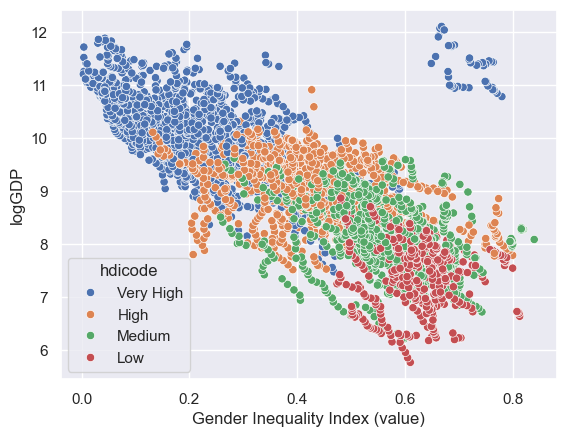

In [22]:
sns.scatterplot(data=GDP_GII, x=HDR_idx['gii'], y='logGDP', hue='hdicode')
plt.show()

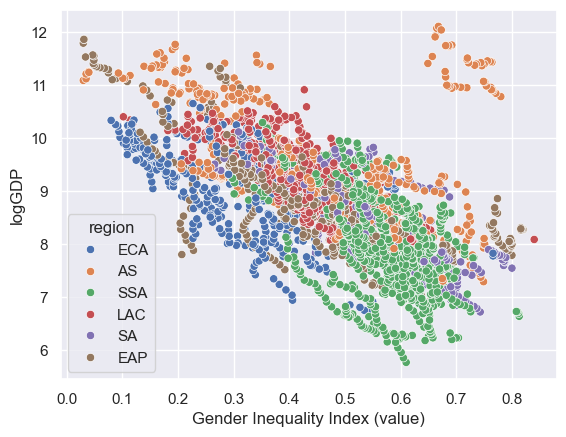

In [23]:
sns.scatterplot(data=GDP_GII, x=HDR_idx['gii'], y='logGDP', hue='region')
plt.show()

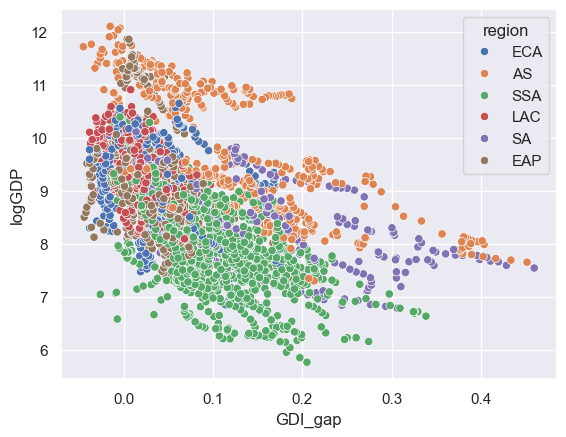

In [24]:
sns.scatterplot(data=GDP_GDI, x='GDI_gap', y='logGDP', hue='region')
plt.show()

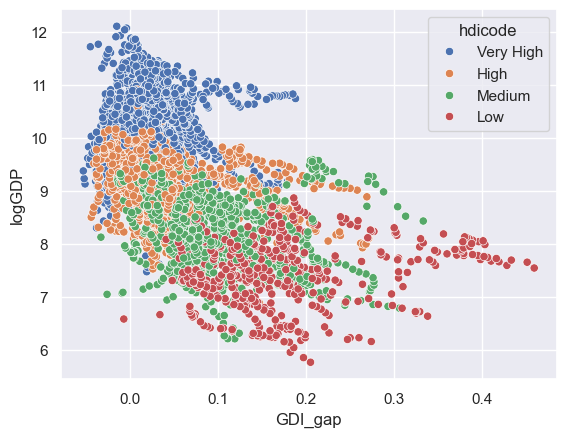

In [25]:
sns.scatterplot(data=GDP_GDI, x='GDI_gap', y='logGDP', hue='hdicode')
plt.show()

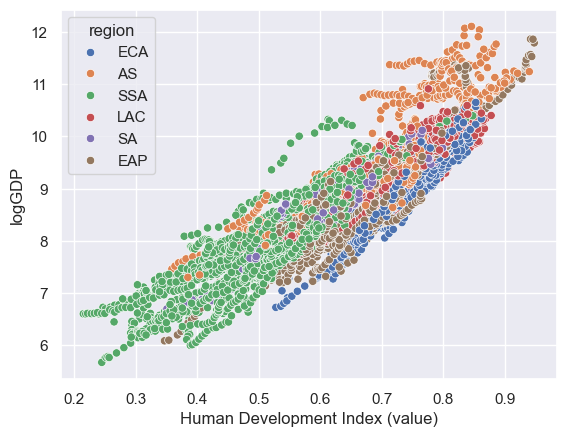

In [26]:
sns.scatterplot(data=GDP_HDI, x=HDR_idx['hdi'], y='logGDP', hue='region')
plt.show()

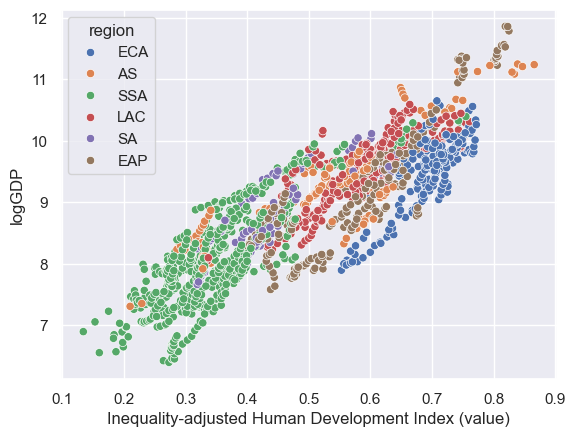

In [27]:
sns.scatterplot(data=GDP_IHDI, x=HDR_idx['ihdi'], y='logGDP', hue='region')
plt.show()

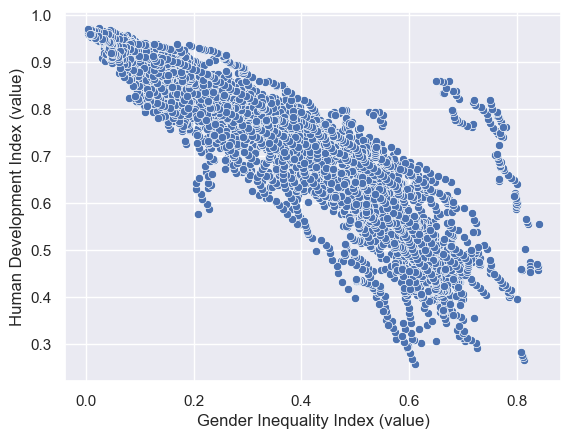

In [28]:
sns.scatterplot(data=HDI_GII, x=HDR_idx['gii'], y='Human Development Index (value)')
plt.show()

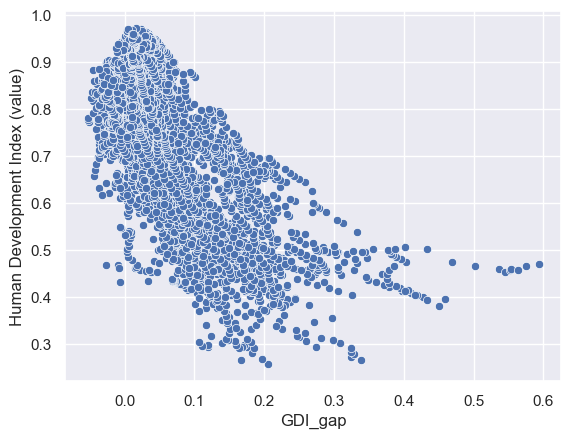

In [29]:
sns.scatterplot(data=HDI_GDI, x='GDI_gap', y='Human Development Index (value)')
plt.show()

# Simple regressions

In [30]:
Panel_GII = PrepareData(GDP_GII,HDR_idx['gii']) # Prepare the GII data
Panel_GDI = PrepareData(GDP_GDI,HDR_idx['gdi']) # Prepare the GDI data
Panel_HDI = PrepareData(GDP_HDI,HDR_idx['hdi']) # Prepare the HDI data
Panel_IHDI = PrepareData(GDP_IHDI,HDR_idx['ihdi']) # Prepare the IHDI data

Panel_GII_GDI = PrepareData(GDP_GII_GDI,HDR_idx['gii']) # Prepare the GII+GDI data
Panel_GII_GDI = PrepareData(Panel_GII_GDI,HDR_idx['gdi']) # Prepare the GII+GDI data

Panel_GII_HDI = PrepareData(GDP_GII_HDI,HDR_idx['gii']) # Prepare the GII+HDI data
Panel_GII_HDI = PrepareData(Panel_GII_HDI,HDR_idx['hdi']) # Prepare the GII+HDI data

In [31]:
Regression(Panel_GII, independent_vars = [HDR_idx['gii']+'_shifted'], dependent_var = 'logGDP')

Dep. Variable:,logGDP,R-squared:,0.0025
Estimator:,PanelOLS,R-squared (Between):,-0.0600
No. Observations:,4357,R-squared (Within):,-0.0434
Date:,"Thu, May 08 2025",R-squared (Overall):,-0.0502
Time:,17:51:13,Log-likelihood,1548.0
Cov. Estimator:,Clustered,,
,,F-statistic:,10.232
Entities:,170,P-value,0.0014
Avg Obs:,25.629,Distribution:,"F(1,4154)"
Min Obs:,1.0000,,
Max Obs:,33.000,F-statistic (robust):,0.2214


In [32]:
Regression(Panel_GDI, independent_vars = ['GDI_gap'], dependent_var = 'logGDP')

Dep. Variable:,logGDP,R-squared:,0.0037
Estimator:,PanelOLS,R-squared (Between):,0.0353
No. Observations:,4824,R-squared (Within):,0.0436
Date:,"Thu, May 08 2025",R-squared (Overall):,0.0419
Time:,17:51:14,Log-likelihood,1360.1
Cov. Estimator:,Clustered,,
,,F-statistic:,17.302
Entities:,182,P-value,0.0000
Avg Obs:,26.505,Distribution:,"F(1,4608)"
Min Obs:,2.0000,,
Max Obs:,34.000,F-statistic (robust):,1.1322


In [33]:
Regression(Panel_HDI, independent_vars = [HDR_idx['hdi']+'_shifted'], dependent_var = 'logGDP')

Dep. Variable:,logGDP,R-squared:,0.2160
Estimator:,PanelOLS,R-squared (Between):,0.7710
No. Observations:,5588,R-squared (Within):,0.6694
Date:,"Thu, May 08 2025",R-squared (Overall):,0.7590
Time:,17:51:14,Log-likelihood,1888.6
Cov. Estimator:,Clustered,,
,,F-statistic:,1477.4
Entities:,191,P-value,0.0000
Avg Obs:,29.257,Distribution:,"F(1,5364)"
Min Obs:,1.0000,,
Max Obs:,33.000,F-statistic (robust):,61.630


In [34]:
Regression(Panel_IHDI, independent_vars = [HDR_idx['ihdi']+'_shifted'], dependent_var = 'logGDP')

Dep. Variable:,logGDP,R-squared:,0.0372
Estimator:,PanelOLS,R-squared (Between):,0.5042
No. Observations:,1935,R-squared (Within):,0.2251
Date:,"Thu, May 08 2025",R-squared (Overall):,0.5006
Time:,17:51:15,Log-likelihood,1760.5
Cov. Estimator:,Clustered,,
,,F-statistic:,67.856
Entities:,168,P-value,0.0000
Avg Obs:,11.518,Distribution:,"F(1,1754)"
Min Obs:,1.0000,,
Max Obs:,13.000,F-statistic (robust):,8.7790


In [35]:
Regression(Panel_GII_HDI, independent_vars = [HDR_idx['gii']+'_shifted',HDR_idx['hdi']+'_shifted'], dependent_var = 'logGDP')

Dep. Variable:,logGDP,R-squared:,0.2239
Estimator:,PanelOLS,R-squared (Between):,0.7372
No. Observations:,4305,R-squared (Within):,0.6104
Date:,"Thu, May 08 2025",R-squared (Overall):,0.7268
Time:,17:51:15,Log-likelihood,2088.8
Cov. Estimator:,Clustered,,
,,F-statistic:,591.43
Entities:,170,P-value,0.0000
Avg Obs:,25.324,Distribution:,"F(2,4101)"
Min Obs:,1.0000,,
Max Obs:,33.000,F-statistic (robust):,43.512


In [36]:
Regression(Panel_GII_GDI, independent_vars = [HDR_idx['gii']+'_shifted','HDI female (value)'], dependent_var = 'logGDP')

Dep. Variable:,logGDP,R-squared:,0.1999
Estimator:,PanelOLS,R-squared (Between):,0.6649
No. Observations:,4178,R-squared (Within):,0.5536
Date:,"Thu, May 08 2025",R-squared (Overall):,0.6568
Time:,17:51:16,Log-likelihood,2005.5
Cov. Estimator:,Clustered,,
,,F-statistic:,496.43
Entities:,170,P-value,0.0000
Avg Obs:,24.576,Distribution:,"F(2,3974)"
Min Obs:,1.0000,,
Max Obs:,33.000,F-statistic (robust):,40.154


In [37]:
df1 = pd.merge(GII[['iso3','year',HDR_idx['gii']]], 
         IHDI[['iso3','year','Coefficient of human inequality','Inequality in eduation', 'Inequality in income','Inequality in life expectancy']], 
         on=['iso3','year'], how='inner')
df2 = pd.merge(df1,GDI[['iso3','year','HDI female (value)']], on=['iso3','year'], how='inner')
df3 = pd.merge(df2,GDP[['iso3','year','logGDP']], on=['iso3','year'], how='inner')

df3.columns.name = None
df3.dropna(inplace=True)

In [38]:
Panel_df3 = PrepareData(df3,HDR_idx['gii']) # Prepare the data for regression

In [39]:
indep_vars = df3.columns.tolist()
indep_vars = [col for col in indep_vars if col not in ['iso3', 'year', 'logGDP']]

In [40]:
Regression(df3,independent_vars=indep_vars,dependent_var='logGDP')

/opt/anaconda3/lib/python3.12/site-packages/linearmodels/panel/results.py:89: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")


Dep. Variable:,logGDP,R-squared:,0.1178
Estimator:,PanelOLS,R-squared (Between):,0.5224
No. Observations:,1943,R-squared (Within):,0.2823
Date:,"Thu, May 08 2025",R-squared (Overall):,0.5152
Time:,17:51:16,Log-likelihood,1848.0
Cov. Estimator:,Clustered,,
,,F-statistic:,39.363
Entities:,156,P-value,0.0000
Avg Obs:,12.455,Distribution:,"F(6,1768)"
Min Obs:,1.0000,,
Max Obs:,14.000,F-statistic (robust):,3.7981


In [41]:
corr = df3.iloc[:,2:].corr(method='pearson')
np.fill_diagonal(corr.values, np.nan)
corr = corr.abs()
corr.style.background_gradient(cmap='coolwarm', axis=None)

,Gender Inequality Index (value),Coefficient of human inequality,Inequality in eduation,Inequality in income,Inequality in life expectancy,HDI female (value),logGDP
Gender Inequality Index (value),nan,0.874393,0.786903,0.670985,0.863031,0.912672,0.870030
Coefficient of human inequality,0.874393,nan,0.902339,0.829447,0.907944,0.913203,0.837108
Inequality in eduation,0.786903,0.902339,nan,0.557408,0.793230,0.860749,0.744497
Inequality in income,0.670985,0.829447,0.557408,nan,0.638877,0.638205,0.623660
Inequality in life expectancy,0.863031,0.907944,0.793230,0.638877,nan,0.923381,0.861403
HDI female (value),0.912672,0.913203,0.860749,0.638205,0.923381,nan,0.948092
logGDP,0.870030,0.837108,0.744497,0.623660,0.861403,0.948092,nan


In [42]:
ind = indep_vars.copy()
ind.remove('HDI female (value)')
corr = df3[ind].corr(method='pearson')
np.fill_diagonal(corr.values, np.nan)
corr = corr.abs()
corr.style.background_gradient(cmap='coolwarm', axis=None)

,Gender Inequality Index (value),Coefficient of human inequality,Inequality in eduation,Inequality in income,Inequality in life expectancy
Gender Inequality Index (value),nan,0.874393,0.786903,0.670985,0.863031
Coefficient of human inequality,0.874393,nan,0.902339,0.829447,0.907944
Inequality in eduation,0.786903,0.902339,nan,0.557408,0.793230
Inequality in income,0.670985,0.829447,0.557408,nan,0.638877
Inequality in life expectancy,0.863031,0.907944,0.793230,0.638877,nan


In [43]:
# Regression(df3,independent_vars=ind,dependent_var='logGDP') Singular matrix

In [44]:
ind = indep_vars.copy()
ind.remove('Coefficient of human inequality')
corr = df3[ind].corr(method='pearson')
np.fill_diagonal(corr.values, np.nan)
corr = corr.abs()
corr.style.background_gradient(cmap='coolwarm', axis=None)

,Gender Inequality Index (value),Inequality in eduation,Inequality in income,Inequality in life expectancy,HDI female (value)
Gender Inequality Index (value),nan,0.786903,0.670985,0.863031,0.912672
Inequality in eduation,0.786903,nan,0.557408,0.793230,0.860749
Inequality in income,0.670985,0.557408,nan,0.638877,0.638205
Inequality in life expectancy,0.863031,0.793230,0.638877,nan,0.923381
HDI female (value),0.912672,0.860749,0.638205,0.923381,nan


In [45]:
Regression(df3,independent_vars=ind,dependent_var='logGDP')

Dep. Variable:,logGDP,R-squared:,0.1157
Estimator:,PanelOLS,R-squared (Between):,0.5248
No. Observations:,1943,R-squared (Within):,0.2838
Date:,"Thu, May 08 2025",R-squared (Overall):,0.5176
Time:,17:51:17,Log-likelihood,1845.7
Cov. Estimator:,Clustered,,
,,F-statistic:,46.290
Entities:,156,P-value,0.0000
Avg Obs:,12.455,Distribution:,"F(5,1769)"
Min Obs:,1.0000,,
Max Obs:,14.000,F-statistic (robust):,5.7247


In [46]:
ind = indep_vars.copy()
ind.remove('Inequality in eduation')
ind.remove('Coefficient of human inequality')
corr = df3[ind].corr(method='pearson')
np.fill_diagonal(corr.values, np.nan)
corr = corr.abs()
corr.style.background_gradient(cmap='coolwarm', axis=None)

,Gender Inequality Index (value),Inequality in income,Inequality in life expectancy,HDI female (value)
Gender Inequality Index (value),nan,0.670985,0.863031,0.912672
Inequality in income,0.670985,nan,0.638877,0.638205
Inequality in life expectancy,0.863031,0.638877,nan,0.923381
HDI female (value),0.912672,0.638205,0.923381,nan


In [47]:
Regression(df3,independent_vars=ind,dependent_var='logGDP')

Dep. Variable:,logGDP,R-squared:,0.0981
Estimator:,PanelOLS,R-squared (Between):,0.6159
No. Observations:,1943,R-squared (Within):,0.3268
Date:,"Thu, May 08 2025",R-squared (Overall):,0.6067
Time:,17:51:17,Log-likelihood,1826.6
Cov. Estimator:,Clustered,,
,,F-statistic:,48.155
Entities:,156,P-value,0.0000
Avg Obs:,12.455,Distribution:,"F(4,1770)"
Min Obs:,1.0000,,
Max Obs:,14.000,F-statistic (robust):,5.6573


In [56]:
df4 = pd.merge(GDP_GII_HDI[['logGDP',HDR_idx['gii'],HDR_idx['hdi'],'iso3','year']],T[['Total net attendance rate, upper secondary, female (%)','iso3','year']], on=['iso3','year'], how='left')
df4.columns.name = None
df4.dropna(inplace=True)
df4['Total net attendance rate, upper secondary, female (%)'] = df4['Total net attendance rate, upper secondary, female (%)']/100

In [57]:
Panel_df4 = PrepareData(df4,HDR_idx['gii']) # Prepare the data for regression
Panel_df4 = PrepareData(Panel_df4,HDR_idx['hdi']) # Prepare the data for regression

In [58]:
Regression(Panel_df4, independent_vars = [HDR_idx['gii']+'_shifted',HDR_idx['hdi']+'_shifted','Total net attendance rate, upper secondary, female (%)'], dependent_var = 'logGDP')

Dep. Variable:,logGDP,R-squared:,0.0494
Estimator:,PanelOLS,R-squared (Between):,0.3912
No. Observations:,452,R-squared (Within):,0.3094
Date:,"Thu, May 08 2025",R-squared (Overall):,0.4285
Time:,17:54:32,Log-likelihood,488.19
Cov. Estimator:,Clustered,,
,,F-statistic:,5.9443
Entities:,84,P-value,0.0006
Avg Obs:,5.3810,Distribution:,"F(3,343)"
Min Obs:,1.0000,,
Max Obs:,23.000,F-statistic (robust):,1.8370


In [70]:
df5 = pd.merge(GDP_GII_GDI[[HDR_idx['gii'],'HDI female (value)','iso3','year','logGDP']],T[['Total net attendance rate, upper secondary, female (%)','iso3','year']], on=['iso3','year'], how='left')
df5.columns.name = None
df5.dropna(inplace=True)
Panel_df5 = PrepareData(df5,HDR_idx['gii']) # Prepare the data for regression
df5['Total net attendance rate, upper secondary, female (%)'] = df5['Total net attendance rate, upper secondary, female (%)']/100                                                            

In [72]:
Regression(Panel_df5, independent_vars = [HDR_idx['gii']+'_shifted','HDI female (value)','Total net attendance rate, upper secondary, female (%)'], dependent_var = 'logGDP')

Dep. Variable:,logGDP,R-squared:,0.1570
Estimator:,PanelOLS,R-squared (Between):,0.6738
No. Observations:,444,R-squared (Within):,0.5648
Date:,"Thu, May 08 2025",R-squared (Overall):,0.7062
Time:,18:01:29,Log-likelihood,505.45
Cov. Estimator:,Clustered,,
,,F-statistic:,20.796
Entities:,84,P-value,0.0000
Avg Obs:,5.2857,Distribution:,"F(3,335)"
Min Obs:,1.0000,,
Max Obs:,23.000,F-statistic (robust):,4.2591
